# Objective
#### Determine whether the given reviews are positive or negative using all features except SCORE and then check the accuracy using the Score feature using KNN classifier

# 1. Loading data from dataset

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import nltk
import seaborn as sns
from tqdm import tqdm

In [2]:
# Loading data from sqlite3 database ignoring those having rewiew score = 3

connection = sqlite3.connect('./database.sqlite')
dataset = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", connection)

In [3]:
print("The shape of the data in dataset is:", dataset.shape)
print('==' * 60)
dataset.columns                # This will list all the features name in dataset column-wise

The shape of the data in dataset is: (525814, 10)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
# Assigning Positive value to reviews with score>3 and Negative value to reviews with score<3

def assign_pn(score):
    if (score > 3):
        score = 'Positive'
    elif (score < 3):
        score = 'Negative'
    return score

pn = dataset['Score']
pn_assign = pn.map(assign_pn)
dataset['Score'] = pn_assign

In [5]:
print(dataset['Score'].value_counts() )                       # Printing the number of each classes (positive and negative reviews)
print('==' * 60)
print("The shape of the data in dataset is:", dataset.shape)

Positive    443777
Negative     82037
Name: Score, dtype: int64
The shape of the data in dataset is: (525814, 10)


In [6]:
# Printing first few rows as a sample of the dataset
# You may pass the number of rows to be displayed as an argument to the head() method

dataset.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Pre-processing of data

### 2.1 De-duplication of data

In [7]:
# Sorting data based on ProductId

sorted_data = dataset.sort_values('ProductId', ascending=True, axis=0)
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [8]:
# Remove all the data points that exactly match the field values mention below

data = sorted_data.drop_duplicates(subset={'UserId', 'Time', 'Text'}, keep='first', inplace=False)
data.shape

(364133, 10)

In [9]:
# Check what percentage of original data is remaining

percentage = (data.shape[0] / dataset.shape[0]) * 100
print(percentage)

69.25129418387492


In [10]:
# Removing the reviews having HelpfulnessNumerator greater than HelpfulnessDenominator

data = data[data.HelpfulnessDenominator >= data.HelpfulnessNumerator]
data.shape

(364131, 10)

Positive    307026
Negative     57105
Name: Score, dtype: int64

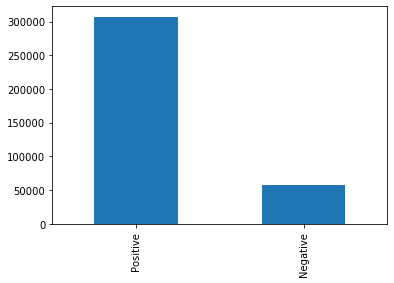

In [11]:
# Getting the number of positive and negative reviews

data['Score'].value_counts().plot(kind='bar')
data['Score'].value_counts()

### 2.2 Data Cleaning

In [12]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [13]:
# Find sentences containing html tags

i = 0
for sentence in data['Text'].values:
    if (len(re.findall('<.*?>', sentence))):
        print("Total number of html tags present:", i)
        print("=="*60)
        print(sentence)
        break
    i += 1

Total number of html tags present: 6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
# Function to remove texts with html tags(<...>)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')                  # Select ANY text with < > tags
    cleanText = re.sub(cleanr, ' ', sentence)     # Replace texts enclosed in < > with white space
    return cleanText

In [15]:
# Function to remove punctuation marks(.,?/:;)

def cleanPunctuation(sentence):
    cleanp = re.sub(r'[?|$|.|!]',r'', sentence)
    cleanp = re.sub(r'[.|,|)|(|\|/]',r' ', cleanp)
    return cleanp

In [16]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stopWords = set(stopwords.words('english'))
print(stopWords)

{'hadn', 'itself', 'doing', 'how', "wasn't", 'there', 'down', 'at', 'll', 're', "mustn't", 'haven', "needn't", 'in', 'have', 'we', 'very', 'hasn', 'i', 'them', 'these', 'an', 'do', 'too', 'myself', "it's", 'being', 'her', 'off', "doesn't", 'shouldn', 'or', 'most', 'himself', "you'll", 'yourselves', 'o', "you've", 'below', "aren't", "isn't", 'above', 'doesn', 'wasn', 'after', 'she', 'when', 'has', 'it', 'here', 'yours', 'over', 'once', "shouldn't", 'other', 'again', 'ours', "she's", 'aren', 'ourselves', 'having', 'weren', 'into', 't', 'wouldn', 'up', 'what', 'its', 'am', 'our', 'few', 'why', "hasn't", 'such', "haven't", 'more', "shan't", 'don', 'who', 'mightn', "won't", 'd', 'did', 'yourself', 'same', 'shan', 'but', 'm', 'by', 'while', 'won', 'between', 'own', 'from', 'are', 'the', "didn't", 'during', 'both', 'was', 'me', 'now', "you'd", 'so', 'as', 'their', 'out', 'couldn', 'were', 'whom', 'hers', 'he', 'isn', 'nor', 'a', 'not', 'needn', 'ma', 'they', 'you', 'his', 'to', 'some', "might

In [17]:
# Initializing SnowBall Stemmer

snowball = SnowballStemmer('english')

In [18]:
# Printing a base-word using snowball stemmer

print(snowball.stem('tasty'))
print(snowball.stem('delicious'))
print(snowball.stem('little'))

tasti
delici
littl


In [19]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

i = 0
initial_str = ''
final_str = []          # Store final string of clean words
positive_words = []     # Store words from positive reviews here
negative_words = []     # Store words from negative reviews here
s = ''

for sentence in tqdm(data['Text'].values):
    filtered_sentence = []
    sentence = cleanHtml(sentence)          # Remove html tags
    for words in sentence.split():
        for word in cleanPunctuation(words).split():
            if ((word.isalpha()) & (len(word) > 2)):
                if (word.lower() not in stopWords):
                    s = (snowball.stem(word.lower()).encode('utf-8'))
                    filtered_sentence.append(s)
                    if ((data['Score'].values)[i] == 'Positive'):
                        positive_words.append(s)
                    if ((data['Score'].values)[i] == 'Negative'):
                        negative_words.append(s)
                else:
                    continue
            else:
                continue
    initial_str = b" ".join(filtered_sentence)      # Final string of clean words
    final_str.append(initial_str)
    i += 1

100%|██████████| 364131/364131 [05:11<00:00, 1170.49it/s]


In [20]:
# Adding a column in dataset and storing cleaned text in it.

data['CleanedText'] = final_str
data['CleanedText'] = data['CleanedText'].str.decode("utf-8")

In [21]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# 3. Time-based splitting of data

In [22]:
# Sorting data based on time

time_sort = data.sort_values('Time', ascending=True, axis=0, na_position='last')       # na_postion='last' puts NaNs at the end
time_sort.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
# Splitting data into Train, Test and Cross-validation

X = time_sort['CleanedText']
Y = time_sort['Score']

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.25)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.3)

In [25]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (191168,) (191168,)
The shape of the CV data is: (81930,) (81930,)
The shape of the test data is: (91033,) (91033,)


# 4. Function to Train and Test Support Vector Machine models

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### 4.1 Train function for Support Vector Machine models

In [27]:
def svm_train(x_train, x_cv, y_train, y_cv, algo):
    alpha = [10**x for x in range(-5, 4)]     # Here alpha serves both for itself and c as well
    accuracy_cv = []

    for i in alpha[0:]:
        if (algo == 'Linear'):
            model=SGDClassifier(alpha=i)
            svm = CalibratedClassifierCV(base_estimator=model)
        elif (algo == 'RBF'):
            svm = SVC(C=i, probability=True)
        svm.fit(x_train, y_train)
        
        prediction = svm.predict(x_cv)
        
        acc_cv = accuracy_score(y_cv, prediction)
        f1_cv = f1_score(y_cv, prediction, average='macro')
        precision_cv = precision_score(y_cv, prediction, average='macro')
        recall_cv = recall_score(y_cv, prediction, average='macro')
        
        print("FOR α =", i)
        print("The accuracy of the model is:", acc_cv*100)
        print("The f1_score of the model is:", f1_cv*100)
        print("The precision_score of the model is:", precision_cv*100)
        print("The recall_score of the model is:", recall_cv*100)
        print("=="*60)
        
        accuracy_cv.append(acc_cv)
        
    # Plot α vs auc_score graph
    plt.plot(alpha, accuracy_cv, 'b-', label="Cross Validation Data")
    plt.legend(loc='lower right')
    plt.title("α v/s Auc Score")
    plt.ylabel('Auc Score')
    plt.xlabel('alpha (α)')
    plt.show()

### 4.2 Test function for Support Vector Machine models

In [28]:
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_confusion_matrix

In [29]:
def svm_test(x_train, y_train, x_test, y_test, optimal_alpha, algo):
    if (algo == 'Linear'):
        model=SGDClassifier(alpha=optimal_alpha)            # Here optimum_alpha serves both for itself and optimal_c as well
        svm = CalibratedClassifierCV(base_estimator=model)
    elif (algo == 'RBF'):
        svm = SVC(C=optimal_alpha, probability=True)        # Here optimum_alpha serves both for itself and optimal_c as well
    svm.fit(x_train, y_train)
    
    prediction = svm.predict(x_test)

    print("The accuracy of the model is:", accuracy_score(y_test, prediction)*100)
    print("The macro f1_score of the model is:", f1_score(y_test, prediction, average = 'macro')*100)
    print("The micro f1_score of the model is:", f1_score(y_test, prediction, average = 'micro')*100)
    print("The precision_score of the model is:", precision_score(y_test, prediction, average='macro')*100)
    print("The recall_score of the model is:", recall_score(y_test, prediction, average='macro')*100)
    print("The precision recall report for data:\n", classification_report(y_test, prediction))
    
    plot_confusion_matrix(y_test, prediction)
    plt.show()

### 4.3 Top 10 Features of Support Vector Machine models

In [31]:
def top_features(x_train, y_train, vectorizer, optimal_alpha, algo):
    all_features = vectorizer.get_feature_names()
    if (algo == 'Linear'):
        model = SGDClassifier(alpha=optimal_alpha)            # Here optimum_alpha serves both for itself and optimal_c as well
    elif (algo == 'RBF'):
        model = SVC(C=optimal_alpha, probability=True)        # Here optimum_alpha serves both for itself and optimal_c as well
    model.fit(x_train, y_train)
    weight = model.coef_
    top_positive = np.argsort(weight)[:,::-1]
    top_negative = np.argsort(weight)
    
    print('These are the Top 10 Positive Features:')
    for i in list(top_positive[0][0:10]):
        print("\t", all_features[i])
        
    print('These are the Top 10 Negative Features:')
    for i in list(top_negative[0][0:10]):
        print("\t", all_features[i])

# 5. Vectorization of splitted of data

### 5.1 Bag of Words (BoW)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

In [33]:
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(x_train)
# Fit should be done only to train data
# After fitting count_vect only learns the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

In [34]:
print("The shape of the training data is:", x_train_bow.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_bow.shape, y_cv.shape)
print("The shape of the test data is:", x_test_bow.shape, y_test.shape)

The shape of the training data is: (191168, 1931880) (191168,)
The shape of the CV data is: (81930, 1931880) (81930,)
The shape of the test data is: (91033, 1931880) (91033,)


### 5.2 Term Frequency - Inverse Document Frequency (tf-idf)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
tfidf_vect = TfidfVectorizer(stop_words=None, ngram_range=(1,2))
tfidf_vect.fit(x_train)
# Fit should be done only to train data
# After fitting tfidf_vect only learnss the vocabulary of x_train i.e unique words(unique n-grams)

# To convert the SENTENCE into numerical vectors, we call transform()
x_train_tfidf = tfidf_vect.transform(x_train)
x_cv_tfidf = tfidf_vect.transform(x_cv)
x_test_tfidf = tfidf_vect.transform(x_test)

In [37]:
print("The shape of the training data is:", x_train_tfidf.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidf.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidf.shape, y_test.shape)

The shape of the training data is: (191168, 1931880) (191168,)
The shape of the CV data is: (81930, 1931880) (81930,)
The shape of the test data is: (91033, 1931880) (91033,)


### 5.3 Word2Vec

In [38]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [39]:
sentence_list = []
for sentence in x_train:
    sentence_list.append(sentence.split())

In [40]:
sentence_list_cv = []
for sentence in x_cv:
    sentence_list_cv.append(sentence.split())

In [41]:
sentence_list_test = []
for sentence in x_test:
    sentence_list_test.append(sentence.split())

In [42]:
# Train your own Word2Vec model using your own train text corpus 

w2v_train_model = Word2Vec(sentence_list, min_count=5, size=50, workers=4)          # Considers only those words that occured atleast 5 times
print(type(w2v_train_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [43]:
w2v_words = list(w2v_train_model.wv.vocab)
print("The number of words that occured minimum 5 times:", len(w2v_words))
print("These are the sample words from index 0 to 50:/n", w2v_words[0:50])

The number of words that occured minimum 5 times: 16456
These are the sample words from index 0 to 50:/n ['aroma', 'greatest', 'aspect', 'coffe', 'liter', 'open', 'entir', 'room', 'smell', 'rich', 'vanilla', 'tast', 'bold', 'smooth', 'work', 'well', 'breakfast', 'anytim', 'day', 'would', 'compar', 'dunkin', 'donut', 'howev', 'less', 'complaint', 'bag', 'tri', 'basic', 'cut', 'whole', 'thing', 'fair', 'may', 'got', 'abnorm', 'seal', 'absolut', 'favorit', 'marinad', 'chicken', 'beef', 'venison', 'use', 'grill', 'meat', 'also', 'saut', 'onion', 'mushroom']


### 5.4 Average Word2Vec

In [44]:
avg_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):          # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_train_vector.append(sentence_vector)
avg_train_vector = np.array(avg_train_vector)

100%|██████████| 191168/191168 [00:21<00:00, 9082.91it/s]


In [45]:
print(avg_train_vector.shape)
print(avg_train_vector[0])

(191168, 50)
[-0.06350373  1.5137884  -0.9430755   1.12278681 -0.13760446 -0.76098048
  0.08197785  0.35025594 -1.11403085  0.57274527  0.11419332 -0.32974786
 -1.2585566  -0.04771347  0.73677397 -0.99433791  0.51274831 -0.51546284
  0.29796698  0.05987203 -0.71322644 -0.0227671  -0.13451419 -0.83898607
  0.11192682 -0.47378385  0.69713531  0.47718148 -0.58468431  0.53226705
  0.3942625   0.44121555 -0.14767597  0.14474413  0.15120894  1.10574399
  1.12273795 -0.36850406 -0.43410518 -0.04269999  0.6901423   0.45516318
  0.26693645 -0.53579564  0.40502283  1.68304621 -0.07352724  0.39589029
  0.20794846 -0.09448708]


In [46]:
avg_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):       # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_cv_vector.append(sentence_vector)
avg_cv_vector = np.array(avg_cv_vector)

100%|██████████| 81930/81930 [00:09<00:00, 9095.19it/s]


In [47]:
print(avg_cv_vector.shape)
print(avg_cv_vector[0])

(81930, 50)
[ 0.31747478  0.75099173 -0.30000654  0.93157064  0.10747908  0.13705613
  0.37819605  0.13774024 -1.355894    0.40810279 -0.35282248  0.53928066
 -0.26747118 -0.06787945 -0.308134   -0.12939394  0.63218093  0.63570925
  0.05658553  0.07223037  0.13247127  0.02812386 -0.50268894 -0.2207473
 -0.17014461  0.50157521 -0.44754249 -0.43912923 -0.39683063  0.8752054
  0.37310731 -0.3259411  -0.51061278 -0.30475404  0.79628942  0.30067887
 -0.04448922 -0.75837115  0.65302731  0.48940734  0.17789104 -0.26929269
 -0.60144313  0.1171654   0.17903162  1.04515519  0.1458677  -1.03972113
 -1.23744916  0.41272254]


In [48]:
avg_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):     # For each sentence/review
    sentence_vector = np.zeros(50)            # As word vectors are of zero length
    count_words = 0                           # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            sentence_vector += vect
            count_words += 1
        except:
            pass
    if count_words != 0:
        sentence_vector /= count_words
    avg_test_vector.append(sentence_vector)
avg_test_vector = np.array(avg_test_vector)

100%|██████████| 91033/91033 [00:09<00:00, 9163.74it/s]


In [49]:
print(avg_test_vector.shape)
print(avg_test_vector[0])

(91033, 50)
[-0.09768148  0.41877554 -0.87718358  0.30577701 -0.01712659 -0.16750296
  0.09557414 -0.1959483  -0.59078463  0.93309552 -0.46290252 -0.67552689
 -0.51698352  0.35768515 -0.03511771 -0.67955586 -0.14324086 -0.01833543
  0.20274868  0.52726822 -0.11447823  0.13928192  0.02465419 -0.17365359
  0.21538604 -0.18823635  0.24600279  0.78752885 -0.26346159  0.37207237
 -0.34623763 -0.32666688 -0.43070353  0.09174812  0.08444377  0.73419502
  0.77011738  0.20171509 -0.2672882  -0.23390421  0.62298034  0.75212719
  0.64710116 -0.47846581  0.37345036  1.25556061  0.06388412 -0.01146499
  0.54814563 -0.10936842]


In [50]:
x_train_avgw2v = avg_train_vector
x_cv_avgw2v = avg_cv_vector
x_test_avgw2v = avg_test_vector

In [51]:
print("The shape of the training data is:", x_train_avgw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_avgw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_avgw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


### 5.5 TF-IDF Weighed Word2Vec

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tfidf_vect.fit_transform(x_train)
tfidf_feat = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_feat, list(tfidf_vect.idf_)))

In [54]:
tfidf_train_vector = []                         # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list):            # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_train_vector.append(sentence_vector)
tfidf_train_vector = np.array(tfidf_train_vector)

100%|██████████| 191168/191168 [00:46<00:00, 4153.18it/s]


In [55]:
print(tfidf_train_vector.shape)
print(tfidf_train_vector[0])

(191168, 50)
[-0.10221206  1.89875616 -1.34618624  1.61504948 -0.40774847 -1.14750711
 -0.03059044 -0.00968472 -1.58352375  0.38335024  0.26177424 -0.37932498
 -1.72336409  0.05982293  1.44069778 -1.67285568  0.45792977 -0.98029553
  0.7580675  -0.15252868 -0.53851882 -0.56527109  0.20874981 -1.08687511
 -0.07732165 -1.04343701  0.85936904  0.3527204  -0.62703732  0.81826822
  0.6705326   0.72108277 -0.30554008  0.22976733  0.32249883  1.45065035
  1.47566067 -0.24516644 -0.89181557  0.27589916  1.1453558   0.61594279
  0.39225229 -0.91507241  0.68360356  2.60445994 -0.33613593  0.84959375
  0.15220152  0.02337466]


In [56]:
tfidf_cv_vector = []                            # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_cv):         # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_cv_vector.append(sentence_vector)
tfidf_cv_vector = np.array(tfidf_cv_vector)

100%|██████████| 81930/81930 [00:19<00:00, 4173.97it/s]


In [57]:
print(tfidf_cv_vector.shape)
print(tfidf_cv_vector[0])

(81930, 50)
[ 0.1862532   0.55192983 -0.59367273  0.98062658  0.46088697  0.56314323
  0.77048212 -0.1336849  -2.0235008  -0.01753642 -0.17830739  0.94127205
 -0.51004073 -0.11132502 -0.84838913 -0.39072961  1.05499152  0.21514063
 -0.28984197 -0.28879724  0.20487413 -0.44668246 -0.78226178 -0.48685385
 -0.06184399  0.17929386 -1.12743945 -0.62039114 -0.94044245  1.03751419
  0.61298206 -0.76357863 -1.23507774 -0.51747388  0.70657388  0.1889574
 -0.28788272 -1.48949386  0.69745614  0.33616389  0.79899085 -0.23204091
 -0.53296719  0.07696604  0.39047687  1.32768101  0.07568768 -1.29203221
 -2.07334741  0.80813926]


In [58]:
tfidf_test_vector = []                          # Average w2v for each review/sentence is stored in this array
for sentence in tqdm(sentence_list_test):       # For each sentence/review
    sentence_vector = np.zeros(50)              # As word vectors are of zero length
    weight_sum = 0                              # Num of words with a valid vector in a sentence/review
    for word in sentence:
        try:
            vect = w2v_train_model.wv[word]
            tfidf_weight = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vector += (vect*tfidf_weight)
            weight_sum += tfidf_weight
        except:
            pass
    if weight_sum != 0:
        sentence_vector /= weight_sum
    tfidf_test_vector.append(sentence_vector)
tfidf_test_vector = np.array(tfidf_test_vector)

100%|██████████| 91033/91033 [00:21<00:00, 4241.22it/s]


In [59]:
print(tfidf_test_vector.shape)
print(tfidf_test_vector[0])

(91033, 50)
[ 0.19970935  0.44366907 -1.19113693  1.44822652  0.16591349 -0.6258427
  0.05563547 -0.02622105 -0.66846583  1.16069952 -0.79721209 -1.25607693
 -1.11866036  1.34971929  0.48558985 -1.29925577  0.40440455  0.22994964
  0.45240032  0.70200286 -0.19565016  0.15971934 -0.09646519 -0.63961756
  0.00805794 -0.37879431  0.65911762  1.24479933 -0.72312796  0.58241287
 -1.06448064 -0.32219166 -1.01862994 -0.28054498  0.45782589  1.01482741
  1.26631521  0.13142558 -1.19252764 -0.43688573  0.62140099  1.14938113
  1.10251452 -0.85437465  0.29255095  2.02731193 -0.44716662 -0.26698394
  0.90901445 -0.41409005]


In [60]:
x_train_tfidfw2v = tfidf_train_vector
x_cv_tfidfw2v = tfidf_cv_vector
x_test_tfidfw2v = tfidf_test_vector

In [61]:
print("The shape of the training data is:", x_train_tfidfw2v.shape, y_train.shape)
print("The shape of the CV data is:", x_cv_tfidfw2v.shape, y_cv.shape)
print("The shape of the test data is:", x_test_tfidfw2v.shape, y_test.shape)

The shape of the training data is: (191168, 50) (191168,)
The shape of the CV data is: (81930, 50) (81930,)
The shape of the test data is: (91033, 50) (91033,)


# 6. Applying Linear Support Vector Machine on Our Model

### 6.1 Bag of Words (BoW)

##### 6.1.1 BoW Linear SVM on Train Data

FOR α = 1e-05
The accuracy of the model is: 92.55584035151959
The f1_score of the model is: 83.8138933953972
The precision_score of the model is: 90.82910918331392
The recall_score of the model is: 79.52905543343515
FOR α = 0.0001
The accuracy of the model is: 92.8927132918345
The f1_score of the model is: 85.19942838143074
The precision_score of the model is: 89.74360417373066
The recall_score of the model is: 81.96196349981247
FOR α = 0.001
The accuracy of the model is: 92.43500549249359
The f1_score of the model is: 84.16551247209847
The precision_score of the model is: 88.8680893273815
The recall_score of the model is: 80.88090095461256
FOR α = 0.01
The accuracy of the model is: 91.41950445502258
The f1_score of the model is: 81.42059460014634
The precision_score of the model is: 87.7005401547043
The recall_score of the model is: 77.55706063715813
FOR α = 0.1
The accuracy of the model is: 85.76101550103748
The f1_score of the model is: 55.63487903412073
The precision_score of the m

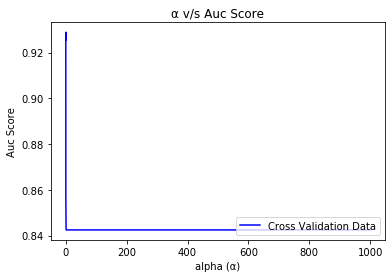

In [62]:
# Find the optimal value of alpha
# This may take several minutes(even hour/s) to run

svm_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='Linear')

##### 6.1.2 BoW Linear SVM on Test Data

The accuracy of the model is: 92.91685432755155
The macro f1_score of the model is: 85.31116636664564
The micro f1_score of the model is: 92.91685432755155
The precision_score of the model is: 89.81720693483706
The recall_score of the model is: 82.0922163266679
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.86      0.66      0.75     14398
    Positive       0.94      0.98      0.96     76635

    accuracy                           0.93     91033
   macro avg       0.90      0.82      0.85     91033
weighted avg       0.93      0.93      0.93     91033



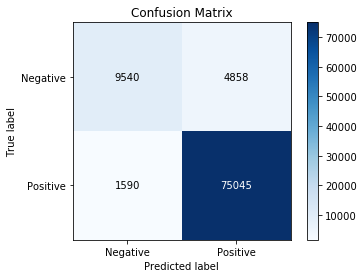

In [63]:
# Testing the final model

svm_test(x_train_bow, y_train, x_test_bow, y_test, optimal_alpha=0.0001, algo='Linear')

##### 6.1.3 Top Ten Features

In [65]:
top_features(x_train_bow, y_train, count_vect, optimal_alpha=0.0001, algo='Linear')

These are the Top 10 Positive Features:
	 high recommend
	 never disappoint
	 awesom
	 delici
	 perfect
	 well worth
	 four star
	 excel
	 pleasant surpris
	 addict
These are the Top 10 Negative Features:
	 two star
	 worst
	 yuck
	 tasteless
	 aw
	 terribl
	 way sweet
	 disappoint
	 horribl
	 usual love


### 6.2 Term Frequency - Inverse Document Frequency (tf-idf)

##### 6.2.1 TF-IDF Linear SVM on Train Data

FOR α = 1e-05
The accuracy of the model is: 93.29793726351764
The f1_score of the model is: 86.57187793677824
The precision_score of the model is: 89.20102373260585
The recall_score of the model is: 84.43228828359383
FOR α = 0.0001
The accuracy of the model is: 92.07982424020506
The f1_score of the model is: 83.77439178006874
The precision_score of the model is: 87.2766871600998
The recall_score of the model is: 81.142522257555
FOR α = 0.001
The accuracy of the model is: 91.9065055535213
The f1_score of the model is: 83.35135023342843
The precision_score of the model is: 87.01821087621231
The recall_score of the model is: 80.63652574811096
FOR α = 0.01
The accuracy of the model is: 91.91016721591603
The f1_score of the model is: 83.3582833824548
The precision_score of the model is: 87.02772315878595
The recall_score of the model is: 80.64184840743638
FOR α = 0.1
The accuracy of the model is: 84.24630782375199
The f1_score of the model is: 45.724828257802095
The precision_score of the m

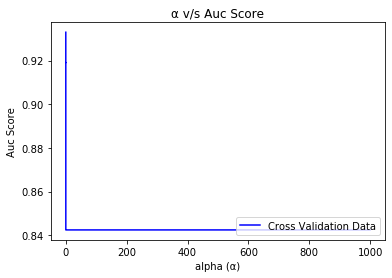

In [66]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='Linear')

##### 6.2.2 TF-IDF Linear SVM on Test Data

The accuracy of the model is: 93.28814825392989
The macro f1_score of the model is: 86.60086934285886
The micro f1_score of the model is: 93.28814825392989
The precision_score of the model is: 89.21327454002532
The recall_score of the model is: 84.47306223063882
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.84      0.72      0.77     14398
    Positive       0.95      0.97      0.96     76635

    accuracy                           0.93     91033
   macro avg       0.89      0.84      0.87     91033
weighted avg       0.93      0.93      0.93     91033



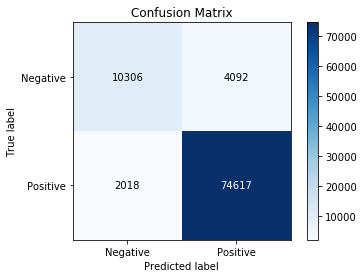

In [68]:
# Testing the final model

svm_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_alpha=0.00001, algo='Linear')

### 6.3 Average Word2vec

##### 6.3.1 Avg W2V Linear SVM on Train Data

FOR α = 1e-05
The accuracy of the model is: 89.56792383742219
The f1_score of the model is: 76.67282104417848
The precision_score of the model is: 83.92385719288482
The recall_score of the model is: 72.79216770845828
FOR α = 0.0001
The accuracy of the model is: 89.68387647992189
The f1_score of the model is: 77.20618036801007
The precision_score of the model is: 83.84641676953919
The recall_score of the model is: 73.47828160187808
FOR α = 0.001
The accuracy of the model is: 89.64603930184303
The f1_score of the model is: 77.23601533386687
The precision_score of the model is: 83.58589335284027
The recall_score of the model is: 73.60385044106413
FOR α = 0.01
The accuracy of the model is: 89.57036494568534
The f1_score of the model is: 77.06600405950343
The precision_score of the model is: 83.38793988335442
The recall_score of the model is: 73.45500534330746
FOR α = 0.1
The accuracy of the model is: 89.32747467350177
The f1_score of the model is: 76.43186453170182
The precision_score of t

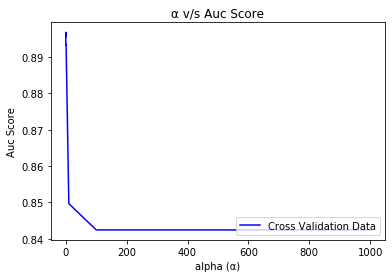

In [71]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, algo='Linear')

##### 6.3.2 Avg W2V Linear SVM on Test Data

The accuracy of the model is: 89.600474553184
The macro f1_score of the model is: 77.17018530124842
The micro f1_score of the model is: 89.600474553184
The precision_score of the model is: 83.61305248650368
The recall_score of the model is: 73.51461784530309
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.76      0.50      0.60     14398
    Positive       0.91      0.97      0.94     76635

    accuracy                           0.90     91033
   macro avg       0.84      0.74      0.77     91033
weighted avg       0.89      0.90      0.89     91033



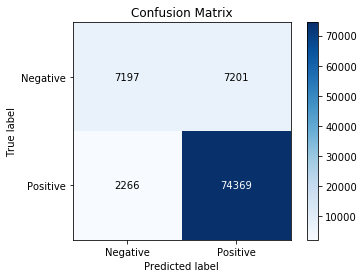

In [72]:
# Testing the final model

svm_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, optimal_alpha=0.0001, algo='Linear')

### 6.4 TF_IDF Weighed Word2vec

##### 6.4.1 TF-IDF Linear SVM on Train Data

FOR α = 1e-05
The accuracy of the model is: 86.28585377761505
The f1_score of the model is: 63.14286506616283
The precision_score of the model is: 78.74870821174436
The recall_score of the model is: 60.29983845375083
FOR α = 0.0001
The accuracy of the model is: 86.67276943732455
The f1_score of the model is: 65.84493682724957
The precision_score of the model is: 78.74619741973363
The recall_score of the model is: 62.5136385813979
FOR α = 0.001
The accuracy of the model is: 86.81191260832418
The f1_score of the model is: 67.00748445052382
The precision_score of the model is: 78.52968062860329
The recall_score of the model is: 63.56625671887313
FOR α = 0.01
The accuracy of the model is: 86.75698767240327
The f1_score of the model is: 66.97782811629747
The precision_score of the model is: 78.21537356094674
The recall_score of the model is: 63.57145253730234
FOR α = 0.1
The accuracy of the model is: 86.75576711827169
The f1_score of the model is: 66.89521584593732
The precision_score of th

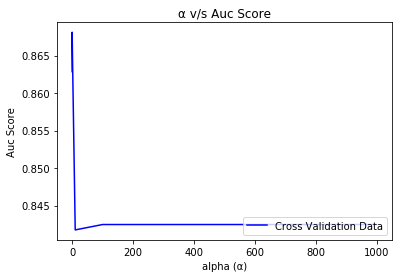

In [73]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, algo='Linear')

##### 6.4.2 TF-IDF W2V Linear SVM on Test Data

The accuracy of the model is: 86.60815308734196
The macro f1_score of the model is: 66.48309892279931
The micro f1_score of the model is: 86.60815308734195
The precision_score of the model is: 78.02045514606021
The recall_score of the model is: 63.14684658443704
The precision recall report for data:
               precision    recall  f1-score   support

    Negative       0.68      0.29      0.41     14398
    Positive       0.88      0.97      0.92     76635

    accuracy                           0.87     91033
   macro avg       0.78      0.63      0.66     91033
weighted avg       0.85      0.87      0.84     91033



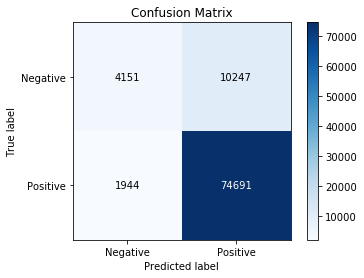

In [74]:
# Testing the final model

svm_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, optimal_alpha=0.001, algo='Linear')

# 7. Applying Radial Basis Function (RBF) Support Vector Machine on Our Model

##### Radial Basis Function (RBF) is one of the kernel of Support Vector Machine (SVM) algorithm. The Time Complexity of the Kernal SVM (not Linear SVM) is in the order of 'n²', where 'n' is the number of data points present in the dataset. So, it is not considered wise to use SVM with large dataset like the one we are currently working on.

##### Because of this reason I am not Training my model using RBF SVM here. However, if you wish to train the model anyway, you can use the below code. The code below is fine to go through. 

### 7.1 Bag of Words (BoW)

##### 7.1.1 BoW RBF Support Vector Machine on Train Data

In [ ]:
# Find the optimal value of alpha
# This may take several minutes(even hour/s) to run

svm_train(x_train_bow, x_cv_bow, y_train, y_cv, algo='RBF')

##### 7.1.2 BoW RBF Support Vector Machine on Test Data

In [ ]:
# Testing the final model

svm_test(x_train_bow, y_train, x_test_bow, y_test, optimal_alpha=0.1, algo='RBF')

##### 7.1.3 Top Ten Features

In [ ]:
top_features(x_train_bow, y_train, count_vect, optimal_alpha=alpha, algo='RBF')

### 7.2 Term Frequency -Inverse Document Frequency (TF-IDF)

##### 7.2.1 TF-IDF RBF Support Vector Machine on Train Data

In [ ]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_tfidf, x_cv_tfidf, y_train, y_cv, algo='RBF')

##### 7.2.2 TF-IDF RBF Support Vector Machine on Test Data

In [ ]:
# Testing the final model

svm_test(x_train_tfidf, y_train, x_test_tfidf, y_test, optimal_alpha=alpha, algo='RBF')

##### 7.2.3 Top Ten Features

In [ ]:
top_features(x_train_tfidf, y_train, tfidf_vect, optimal_alpha=alpha, algo='RBF')

### 7.3 Average Word2Vec

##### 7.3.1 Avg W2V RBF Support Vector Machine on Train Data

In [ ]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_avgw2v, x_cv_avgw2v, y_train, y_cv, algo='RBF')

##### 7.3.2 Avg W2V RBF Support Vector Machine on Test Data

In [ ]:
# Testing the final model

svm_test(x_train_avgw2v, y_train, x_test_avgw2v, y_test, optimal_alpha=alpha, algo='RBF')

### 7.4 TF-IDF Weighed Word2Vec

##### 7.4.1 TF-IDF W2V RBF Support Vector Machine on Train Data

In [ ]:
# Find the optimal value of alpha
# This may take several minutes to run

svm_train(x_train_tfidfw2v, x_cv_tfidfw2v, y_train, y_cv, algo='RBF')

##### 7.4.2 TF-IDF W2V RBF Support Vector Machine on Test Data

In [ ]:
# Testing the final model

svm_test(x_train_tfidfw2v, y_train, x_test_tfidfw2v, y_test, optimal_alpha=alpha, algo='RBF')